In [1]:
import mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# mnist_loader loads the data from ../data/mnist.pkl.gz file.
# size of training_data is 50000, validation_data 10000, test_data 10000

# training_data is a 2D array
# example:
# training_data[0] is the first entry
# training_data[0][0] is the data of 784 pixels, that is the representation of the first entry
# training_data[0][1] is the label

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [3]:
# print de structuur van het N+1-th nummer
testnumber = training_data[0]

# voorbeeld van een moeilijk leesbaar nummer
# testnumber = test_data[8]

In [4]:
# Print list of the pixels
print len(testnumber[0])
print testnumber[0]

784
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [

In [5]:
with np.printoptions(precision=2, suppress=True, linewidth=150):
    print testnumber[0].reshape(-1, 28)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.07 0.07 0.07 0.49 0.53 0.68 0.1  0.65 1.   0.96 0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.12 0.14 0.37 0.6  0.66 0.99 0.99 0.99 0.99 0.99 0.88 0.67 0.99 0.95 0.76 0.25 0.   0.   0.   0.  ]

In [6]:
# label of the number

print list(testnumber[1]).index(1)

# gebruik deze line wanneer testnummer uit test_data set komt
# print testnumber[1]

5


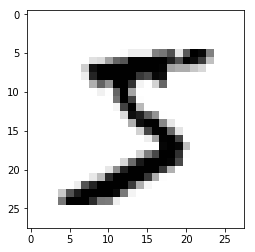

In [7]:
# transfer the number to a image

plt.imshow(testnumber[0].reshape(-1, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

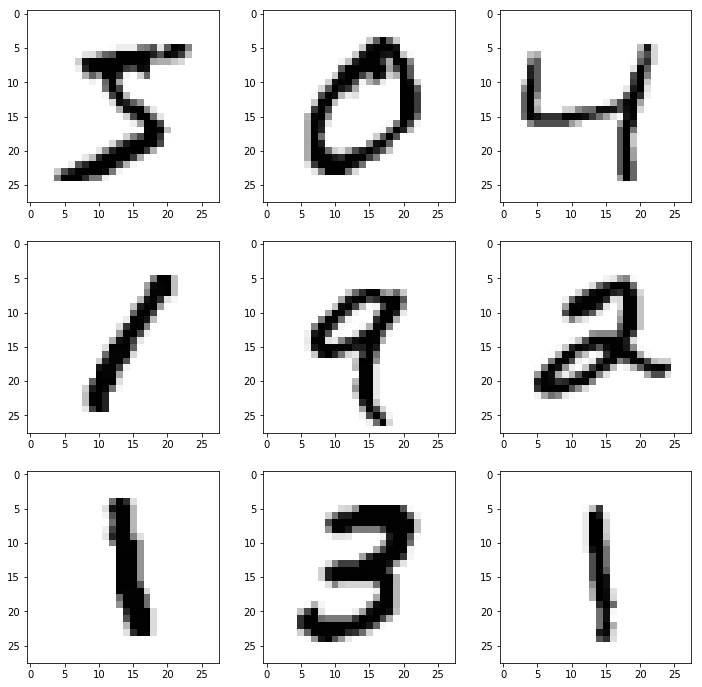

In [8]:
# print image van de eerste 9 nummers

samples = training_data[:9]
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for s, ax in zip(samples, axs):
    ax.imshow(s[0].reshape(-1, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [9]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        if test_data: n_test = len(test_data)
        n = len(training_data)
        testarray = []
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                testarray.append(self.evaluate(test_data))
                print "Iteratie {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Iteratie {0} complete".format(j)
        return testarray

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    def find_wrong(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return test_results

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [10]:
# neural network, input 784 neurons, 2 hidden layers of 16 neurons, output 10 neurons

net = Network([784, 16, 16, 10])

In [ ]:
# result van elke iteratie

testarray = net.SGD(training_data, 10, 10, 2.0, test_data=test_data)

Iteratie 0: 8943 / 10000


In [ ]:
# plot het resultaat

plt.plot(testarray, marker='o', markersize=2)
plt.scatter(testarray.index(max(testarray)), (max(testarray)), alpha=0.5)
plt.show()